# Multi-Class Logistic Regression

## Part 1 (Data Visualization)

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, jaccard_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
df =  pd.read_csv('./Data/penguins.csv').dropna()
labels = df['species'].unique()
features = df.drop(['species'], axis = 1).columns
colors = {'Adelie': 'red' , 'Chinstrap': 'blue' , 'Gentoo': 'green'}

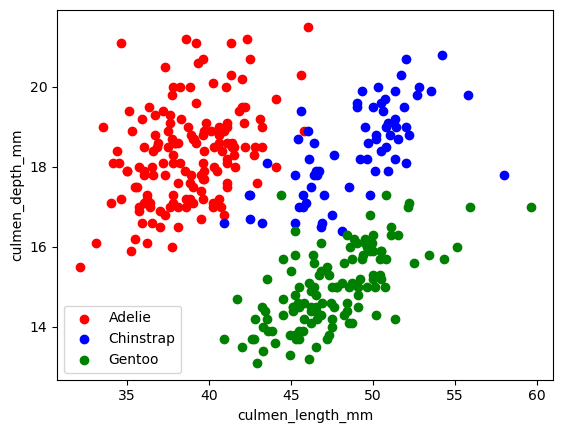

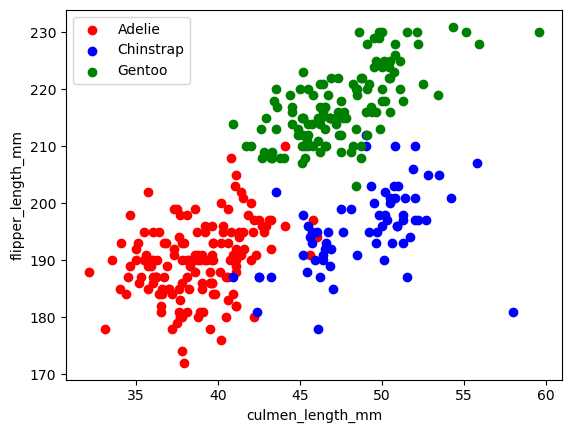

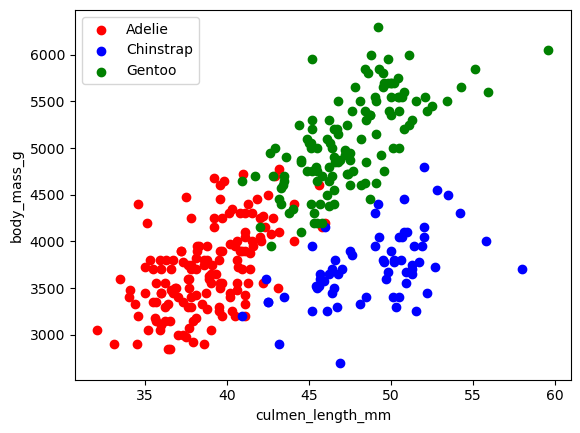

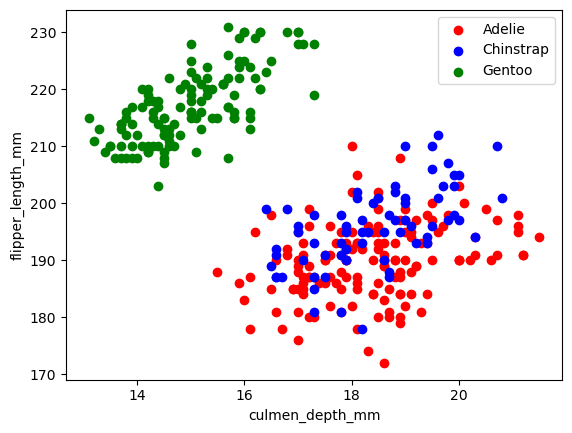

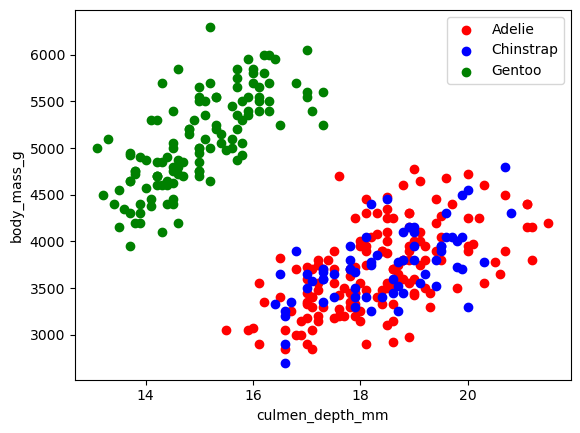

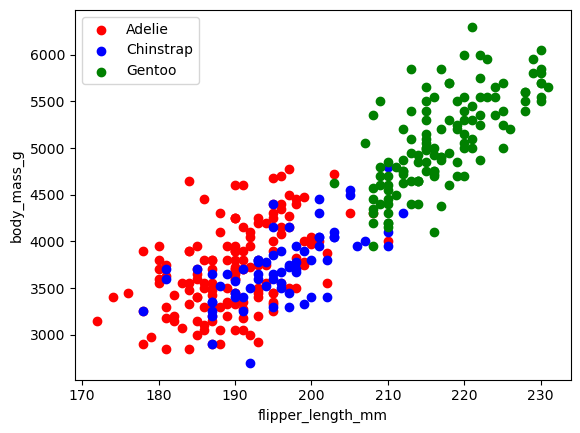

In [3]:
for x_axis, y_axis in combinations(features, 2):
    for label in labels:
        plt.scatter(df[df['species'] == label][x_axis], df[df['species'] == label][y_axis], label = label, c = colors[label])
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

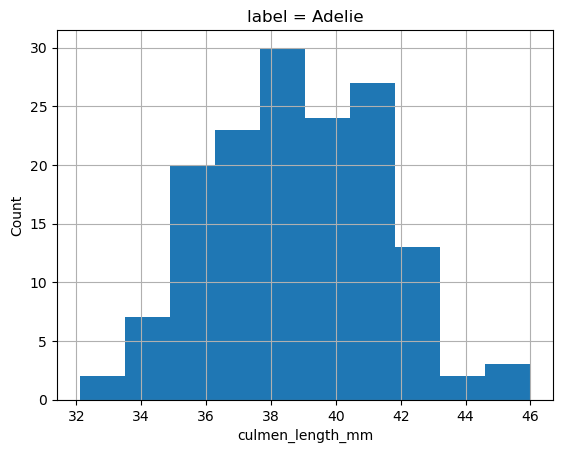

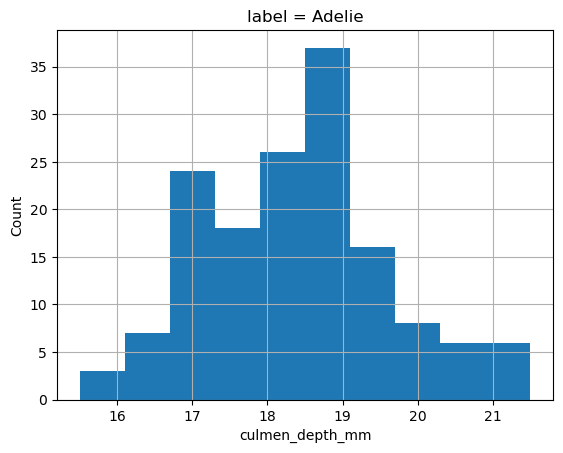

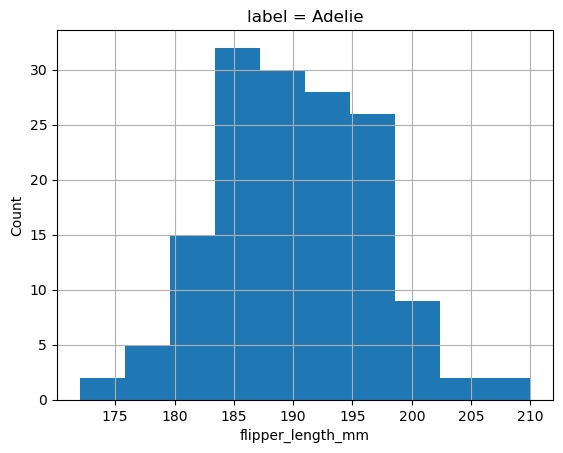

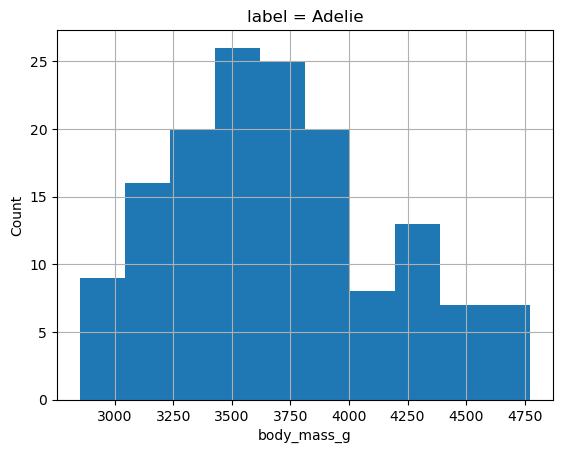

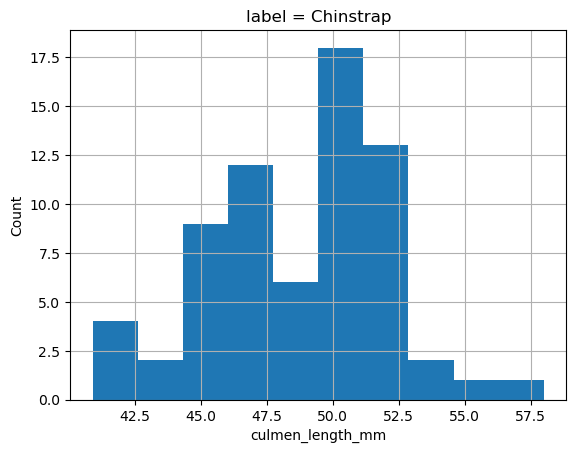

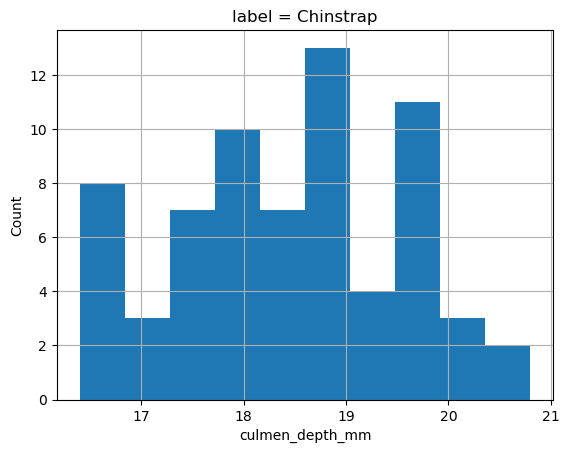

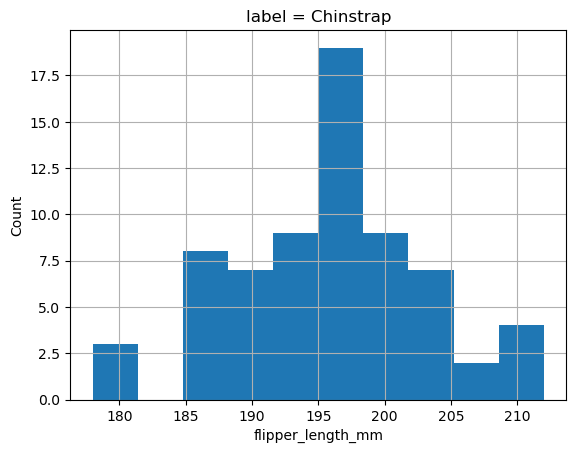

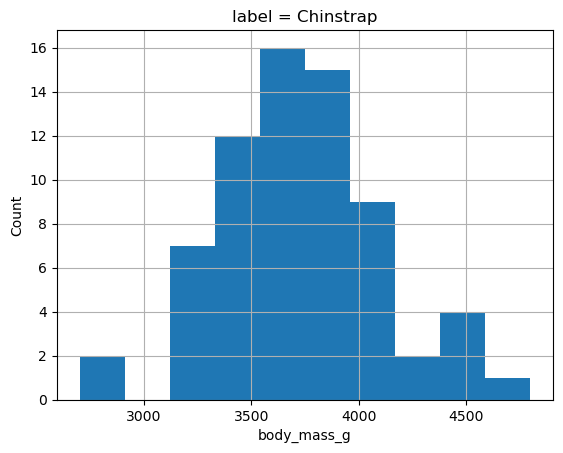

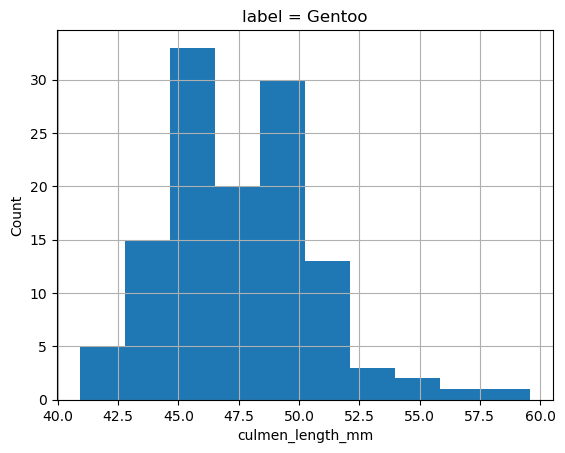

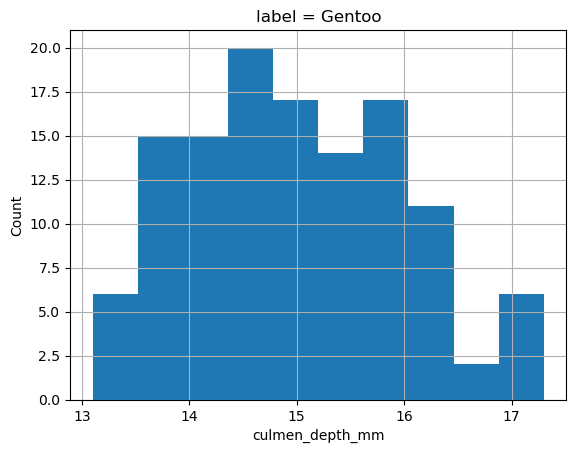

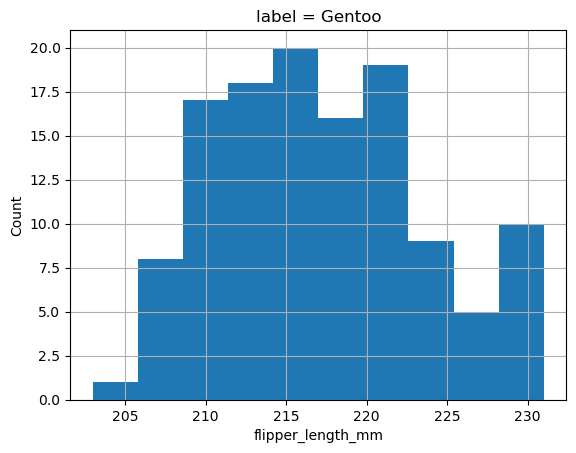

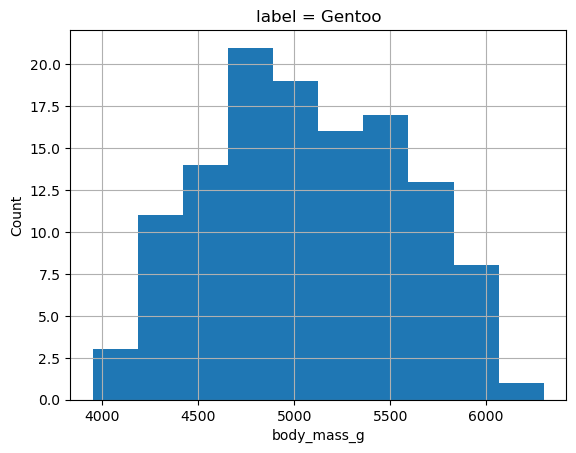

In [4]:
for label in labels:
    for feature in features:       
        df[df['species'] == label][feature].hist()
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.title('label = ' + label)
        plt.show()

## Part 2 (OvR Multi-Class Logistic Regression From Scratch)

In [5]:
class LogisticRegressionOvR:
    def __init__(self, df, learning_rate, iterations):
        self.labels = np.unique(df['species'])
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = {}
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def h_theta(self, X, theta):
        z = X.dot(theta)
        return self.sigmoid(z)
    
    def scale_features(self, X):
        mean = np.mean(X, axis = 0) 
        sd = np.std(X, axis = 0) 
        X_scaled = (X -  mean) / sd
        return X_scaled

    def batch_gradient_descent(self, label):
        X = self.X_train
        y = np.array(self.y_train == label, dtype = int)
        y = y.reshape((y.shape[0], 1))
        m = len(X)
        theta = np.zeros((X.shape[1], 1))
        for iteration in range(self.iterations):
            gradients = 1 / m * X.T.dot(self.h_theta(X, theta) - y)
            theta -= self.learning_rate * gradients
        return theta
    
    def estimate_theta(self):
        for label in self.labels:
            self.theta[label] = self.batch_gradient_descent(label)
    
    def fit(self, X_train, y_train):
        X_train = self.scale_features(X_train)
        self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train
        self.estimate_theta()
    
    def classify_sample(self, x):
        probabilities = []
        for label in self.labels:
            probabilities.append(np.squeeze(self.sigmoid(self.theta[label].T.dot(x))))
        return labels[np.argmax(probabilities)]

    def predict(self, X_test):
        X_test = self.scale_features(X_test)
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        return [self.classify_sample(x) for x in X_test]
        

In [6]:
df = df.sample(frac = 1)
X = df.drop(['species'], axis = 1).to_numpy()
y = df['species'].to_numpy()
split_ratio = 0.8
X_train = X[:int(split_ratio * X.shape[0])]
X_test = X[int(split_ratio * X.shape[0]):]
y_train = y[:int(split_ratio * y.shape[0])]
y_test = y[int(split_ratio * y.shape[0]):]

In [7]:
model = LogisticRegressionOvR(df, 0.1, 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
def confusion_matrix(y_test, y_pred):
    n_classes = len(np.unique(y_test))
    matrix = np.zeros((n_classes, n_classes), dtype = int)
    for (actual, predicted) in zip(y_test, y_pred):
        for i in range(len(labels)):
            for j in range(len(labels)):
                matrix[i][j] += int(actual == labels[i] and predicted == labels[j])
    return matrix

def accuracy_score(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    accuracy = 0
    for i in range(len(labels)):
        accuracy += matrix[i][i]
    accuracy /= np.sum(matrix)
    return accuracy

def precision_score(y_test, y_pred):
    precision = {}
    matrix = confusion_matrix(y_test, y_pred)
    for i in range(len(labels)):       
        denominator = 0
        for j in range(len(labels)):
            denominator += matrix[j][i]
        precision[labels[i]] = matrix[i][i] / denominator   
    return precision
        
def recall_score(y_test, y_pred):
    recall = {}
    matrix = confusion_matrix(y_test, y_pred)
    for i in range(len(labels)):       
        denominator = 0
        for j in range(len(labels)):
            denominator += matrix[i][j]
        recall[labels[i]] = matrix[i][i] / denominator
    return recall

def f1_score(y_test, y_pred):
    f1_score = {}
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    for i in range(len(labels)):
        f1_score[labels[i]] = 2 / ((1 / recall[labels[i]]) + (1 / precision[labels[i]]))
    return f1_score
        
def jaccard_index_score(y_test, y_pred):
    jaccard = {}
    matrix = confusion_matrix(y_test, y_pred)
    for i in range(len(labels)):       
        denominator = 0
        for j in range(len(labels)):
            denominator += matrix[i][j] + matrix[j][i]
        jaccard[labels[i]] = matrix[i][i] / (denominator - matrix[i][i])
    return jaccard

In [9]:
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('accuracy: ', accuracy_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
print('jaccard: ', jaccard_index_score(y_test, y_pred))

confusion matrix:
 [[25  0  0]
 [ 2 18  0]
 [ 0  0 24]]
accuracy:  0.9710144927536232
precision:  {'Adelie': 0.9259259259259259, 'Chinstrap': 1.0, 'Gentoo': 1.0}
recall:  {'Adelie': 1.0, 'Chinstrap': 0.9, 'Gentoo': 1.0}
f1_score:  {'Adelie': 0.9615384615384615, 'Chinstrap': 0.9473684210526315, 'Gentoo': 1.0}
jaccard:  {'Adelie': 0.9259259259259259, 'Chinstrap': 0.9, 'Gentoo': 1.0}


## Part 3 (Multi-Class Logistic Regression Using `sickit-learn` Library)

In [10]:
X = df.drop(['species'], axis = 1).to_numpy()
y = df['species'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3106)

In [11]:
model = LogisticRegression(multi_class = 'ovr', max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
print('confusion matrix:\n', metrics.confusion_matrix(y_test, y_pred))
print('classification report:\n', classification_report(y_test, y_pred))
print('jaccard score: ', jaccard_score(y_test, y_pred, average = None))

confusion matrix:
 [[28  0  0]
 [ 0 18  0]
 [ 0  0 23]]
classification report:
               precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        28
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        23

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

jaccard score:  [1. 1. 1.]


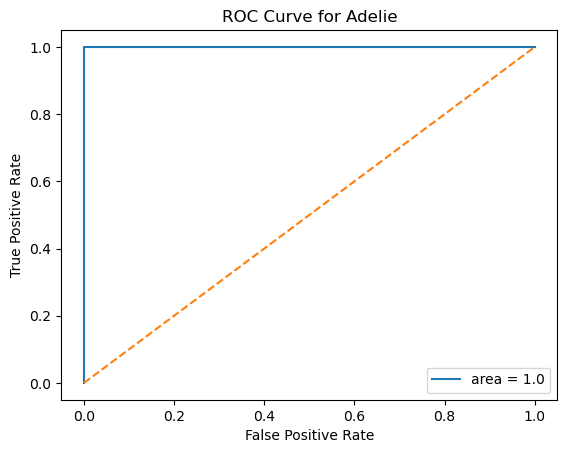

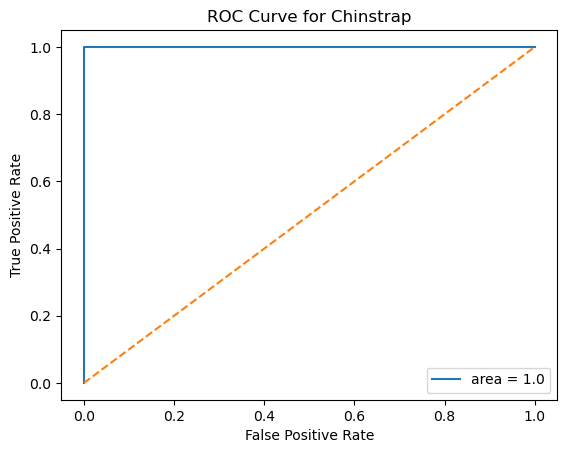

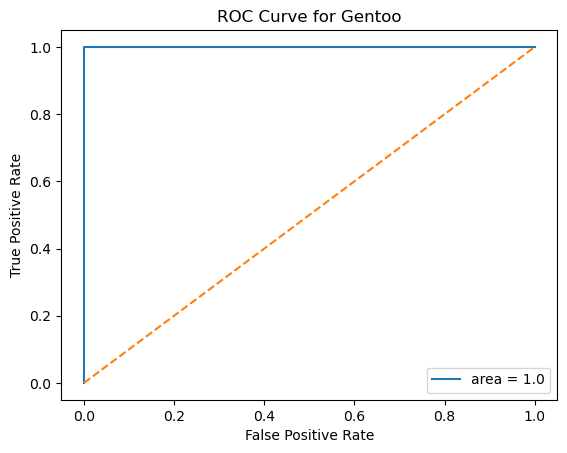

In [13]:
y_test = label_binarize(y_test, classes = list(labels))
y_pred = label_binarize(y_pred, classes = list(labels))

for i in range(len(labels)):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'area = ' + str(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + labels[i])
    plt.legend(loc = 'lower right')
    plt.show()